In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
LENGTH = 65536
SINCOS_WIDTH = 14
DDS_WIDTH = 14
PHASE_WIDTH = 20
AMP_MAX = 2**SINCOS_WIDTH/2 - 1
DDS_MAX = 2**DDS_WIDTH/2 - 1
x = np.arange(4, 4*LENGTH+4, dtype=np.int64)
pinc = -10101/LENGTH
poff = 0
phase_cal = pinc*x + poff
wave_cal = np.round(AMP_MAX*np.cos(2*np.pi*phase_cal)) + 1j*np.round(AMP_MAX*np.sin(2*np.pi*phase_cal))
dds_cal = np.round(DDS_MAX*np.cos(2*np.pi*phase_cal)) + 1j*np.round(DDS_MAX*np.sin(2*np.pi*phase_cal))

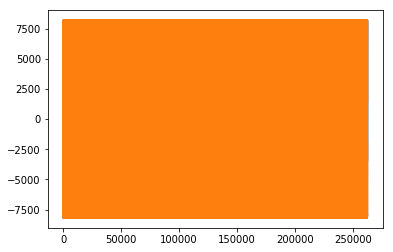

In [3]:
plt.plot(x, wave_cal.real)
plt.plot(x, wave_cal.imag)

In [4]:
ddc_cal = (wave_cal.real*dds_cal.real + wave_cal.imag*dds_cal.imag) + 1j*(wave_cal.imag*dds_cal.real - wave_cal.real*dds_cal.imag)

In [5]:
def pinc2b(pinc_in):
    p_int = int(pinc_in*(2**PHASE_WIDTH))
    p_bytes = p_int.to_bytes(4, 'big', signed=True)
    p_uint = int.from_bytes(p_bytes, 'big', signed=False)
    return f"{p_uint:020b}"[-20:]

## Write pinc and poff to `p_setting.bin`

In [9]:
SIM_DIR = Path('.', 'ddc_quad', 'ddc_quad.sim', 'sim_1', 'behav', 'xsim')
P_SET_PATH = SIM_DIR.joinpath('p_setting.bin')
DIN_PATH_0 = SIM_DIR.joinpath('data_in_0.bin')
DIN_PATH_1 = SIM_DIR.joinpath('data_in_1.bin')
DIN_PATH_2 = SIM_DIR.joinpath('data_in_2.bin')
DIN_PATH_3 = SIM_DIR.joinpath('data_in_3.bin')
if not SIM_DIR.exists():
    SIM_DIR.mkdir(parents=True)

In [10]:
with open(P_SET_PATH, 'w') as f:
    f.write(pinc2b(pinc) + '\n')
    f.write(f'{poff:020b}\n')

In [11]:
def f2b14(value):
    return f"{int.from_bytes(int(value).to_bytes(2, 'big', signed=True), 'big', signed=False):014b}"[-14:]

with open(DIN_PATH_0, 'w') as f:
    for wv in wave_cal[::4]:
        f.write('00' + f2b14(wv.imag)+ '00' + f2b14(wv.real) + '\n')
with open(DIN_PATH_1, 'w') as f:
    for wv in wave_cal[1::4]:
        f.write('00' + f2b14(wv.imag)+ '00' + f2b14(wv.real) + '\n')
with open(DIN_PATH_2, 'w') as f:
    for wv in wave_cal[2::4]:
        f.write('00' + f2b14(wv.imag)+ '00' + f2b14(wv.real) + '\n')
with open(DIN_PATH_3, 'w') as f:
    for wv in wave_cal[3::4]:
        f.write('00' + f2b14(wv.imag)+ '00' + f2b14(wv.real) + '\n')

- stop here and run `run_sim.tcl`

## Analysis

In [22]:
DOUT_PATH = SIM_DIR.joinpath('data_out.bin')

if not DOUT_PATH.exists():
    raise Exception('Simulation has not yet been run')

In [23]:
def data_open(path):
    with open(path) as fd_dout:
        fd_data = fd_dout.readlines()
        data_sim_u = [int(line, 2) for line in fd_data]
        data_sim_b = [int.to_bytes(w, 8, 'big', signed=False) for w in data_sim_u]
        data_sim_q = np.array([int.from_bytes(w[0:4], 'big', signed=True) for w in data_sim_b])
        data_sim_i = np.array([int.from_bytes(w[4:8], 'big', signed=True) for w in data_sim_b])
        ddc_sim = data_sim_i + 1j*data_sim_q
    return ddc_sim

ddc_sim = data_open(DOUT_PATH)

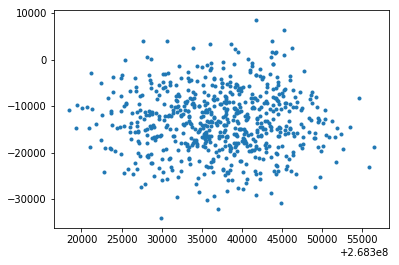

In [30]:
SPARSE = 101
plt.plot(ddc_sim.real[::SPARSE], ddc_sim.imag[::SPARSE], marker='.', ls='')
amax = np.abs(ddc_sim).max()
#plt.xlim([-amax, amax])
#plt.ylim([-amax, amax])

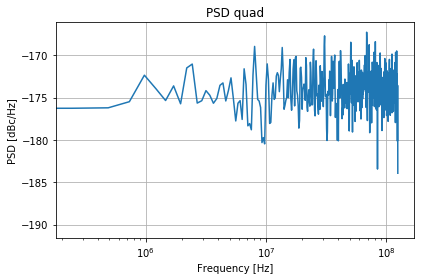

In [40]:
from scipy.signal import welch
ddc_sim_reg = ddc_sim/np.abs(ddc_sim.mean())
f, Pxx_sim = welch(ddc_sim_reg.imag, fs=250e6, nperseg=1024)

plt.semilogx(f, 10*np.log10(Pxx_sim))
plt.title('PSD quad')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [dBc/Hz]')
plt.tight_layout()
plt.grid()
plt.savefig('psd_ddc_quad.pdf')
plt.savefig('psd_ddc_auqd.png', dpi=150)

In [44]:
ddc_sim.real[1]

268335018.0

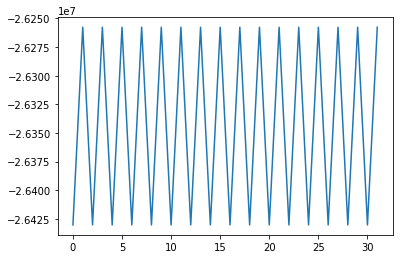

In [54]:
plt.plot(ddc_sim.reshape(-1,2**11).sum(axis=1).imag)